In [ ]:
import numpy as np
import gpflow
from gpflow.config import set_default_float
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

# 1. Synthetic data
NUM_CLASSES = 7
NUM_TRAIN = 700
NUM_TEST  = 200
DIM       = 2

X, y = make_blobs(
    n_samples=NUM_TRAIN + NUM_TEST,
    centers=NUM_CLASSES,
    n_features=DIM,
    cluster_std=1.0,
    random_state=42,
)
x_train, y_train = X[:NUM_TRAIN], y[:NUM_TRAIN]
x_test,  y_test  = X[NUM_TRAIN:], y[NUM_TRAIN:]

# labels as (N,1) ints
Y_train = y_train.reshape(-1, 1).astype(np.int64)

# 2. Build model
set_default_float(np.float64)
kernel     = gpflow.kernels.SquaredExponential(lengthscales=[1.0]*DIM)
likelihood = gpflow.likelihoods.MultiClass(num_classes=NUM_CLASSES)

model = gpflow.models.VGP(
    data=(x_train, Y_train),
    kernel=kernel,
    likelihood=likelihood,
    num_latent_gps=NUM_CLASSES,
)

# 3. Train and record loss history
opt = gpflow.optimizers.Scipy()

opt_result = opt.minimize(
    model.training_loss,
    variables=model.trainable_variables,
    options=dict(maxiter=200),
    compile=True,
    track_loss_history=True
)

# pull out the ELBO (negative loss) history:
loss_history = opt_result.loss_history  # list of scalar losses, one per iteration

# 4. Final accuracy
fmean, _ = model.predict_f(x_test)
y_pred   = np.argmax(fmean, axis=1)
acc      = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.1f}%")


L-BFGS-B iterations: 100%|██████████| 200/200 [01:04<00:00,  3.10it/s, loss=3.185e+02]

Test accuracy: 92.5%


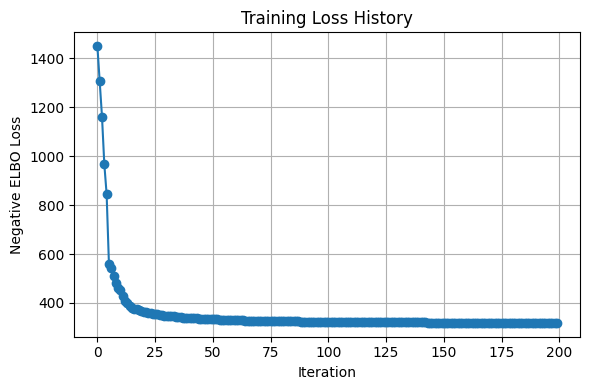

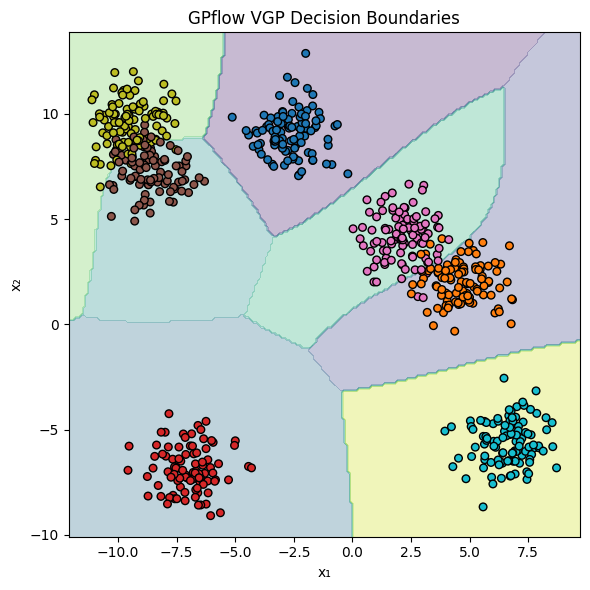

In [8]:
import matplotlib.pyplot as plt

# --- Plot 1: ELBO (actually negative loss) over iterations ---
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Negative ELBO Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: 2D decision boundary ---
# Create a grid over the feature space
x0_min, x0_max = x_train[:,0].min() - 1, x_train[:,0].max() + 1
x1_min, x1_max = x_train[:,1].min() - 1, x_train[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x0_min, x0_max, 200),
    np.linspace(x1_min, x1_max, 200)
)
grid = np.column_stack([xx.ravel(), yy.ravel()])

# Predict class probabilities on the grid
fmean_grid, _ = model.predict_f(grid)
Z = np.argmax(fmean_grid, axis=1).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(NUM_CLASSES+1)-0.5)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, s=30, edgecolor='k', cmap='tab10')
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("GPflow VGP Decision Boundaries")
plt.tight_layout()
plt.show()
